# Causal Inference study with Retail Data

This notebook is inspired in [this article](https://tinyurl.com/mr2edhum) to practice Causal Inference based on synthetic sample generated from the original sample and Regression model.

### Imports

In [2]:
!pip install pingouin --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.1 MB/s eta 0:00:00


In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# DataViz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Stats
import scipy.stats as scs
import pingouin as pg

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

In [5]:
# Load Data
df2 = pd.read_csv('/content/SynthControlStores.csv', parse_dates=['Date'], dtype={'Store': str})
print('Shape:\n',df2.shape)
print('\n')
df2.head(2)

Shape:
 (9420, 3)




,Store,Date,Sales
0,01,2015-07-31,17941.31
1,02,2015-07-31,15162.60


In [4]:
# Data types
df2.dtypes.to_frame().T

,Store,Date,Sales
0,object,datetime64[ns],float64


# What is the competition effect in store 10 performance?

What would have happened if the competitor had not been opened?

* **Treatment Group:** We will set **Store 10** as the treatment group.
* **Control Group:** Other stores without competition within 100m radius #1 to #9.
* **Data**: `Store`, `Date`, `Sales`
* **Intervention date:** 2014, March

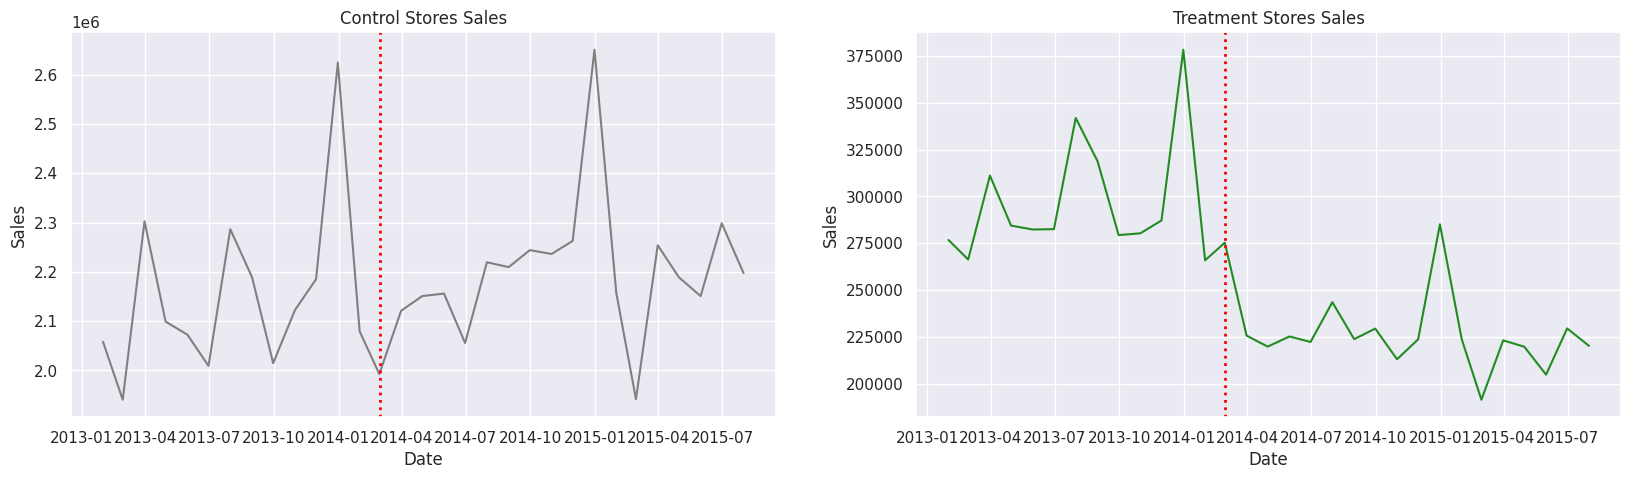

In [6]:
# Set Date of the intervention
intervention_date = pd.to_datetime("2014-03-01")

# Store 10 sales
test_store = df2.query('Store == "10"').resample('ME', on='Date').sum().reset_index()
control_store = df2.query('Store != "10"').resample('ME', on='Date').sum().reset_index()

# Plot
plt.figure(figsize=(20, 5))

# Control
plt.subplot(1, 2, 1)
sns.lineplot(data=control_store,
             x= 'Date', y= 'Sales',
             c='gray')
plt.axvline(x=intervention_date, color="red", linestyle=":", lw=2, label="Opened Competitor for Store 10 ")
plt.title('Control Stores Sales');

# Test
plt.subplot(1, 2, 2)
sns.lineplot(data=test_store,
             x= 'Date', y= 'Sales',
             c='forestgreen')
plt.axvline(x=intervention_date, color="red", linestyle=":", lw=2, label="Opened Competitor for Store 10 ")
plt.title('Treatment Stores Sales');

In [7]:
# Select the control group
control = df2.query('Store != "10"')

# Treatment Group
treat = df2.query('Store == "10"')

In [8]:
'''
In this cell, we are Creating the Control Matrix where the index are the dates, the columns are stores and the values are the sales aggregated by 7 days.
| DATE     | store 1 | store 2 | store n ... |
|----------|---------|---------|-------------|
|2013-01-01| 100     | 200     | 300         |
'''

# Create dataset of control stores sales resampled from daily to weekly (7 days) sales
unit_control = control.pivot(index='Date', columns='Store', values='Sales').resample('7D').sum()

# Agregando as vendas para a Loja 983 para a cada 7 dias
y_sales = treat.set_index('Date')['Sales'].resample('7D').sum()

In [9]:
# View Unit Control
unit_control.head(2)

Store,01,02,03,04,05,06,07,08,09
Date,,,,,,,,,
2013-01-01,70587.40,68066.87,18108.35,26903.07,56196.42,49827.94,79572.42,38530.04,17163.75
2013-01-08,91762.25,79660.31,21843.44,33553.74,67458.67,57957.47,92568.60,41741.65,18716.06


In [10]:
# Filter the control sample with only the dates contained in the treatment dataset
aligned_dates = unit_control.index.intersection(y_sales.index)

# Get the control data filtered with dates from the treatment series
X_sales = unit_control.loc[aligned_dates].fillna(unit_control.median())

# Transform the control data into a single series aggregated as the mean of sales by week
X_sales_mean = X_sales.mean(axis=1)

In [11]:
# View
X_sales_mean.head(3)

,0
Date,
2013-01-01,47217.362222
2013-01-08,56140.243333
2013-01-15,46395.174444


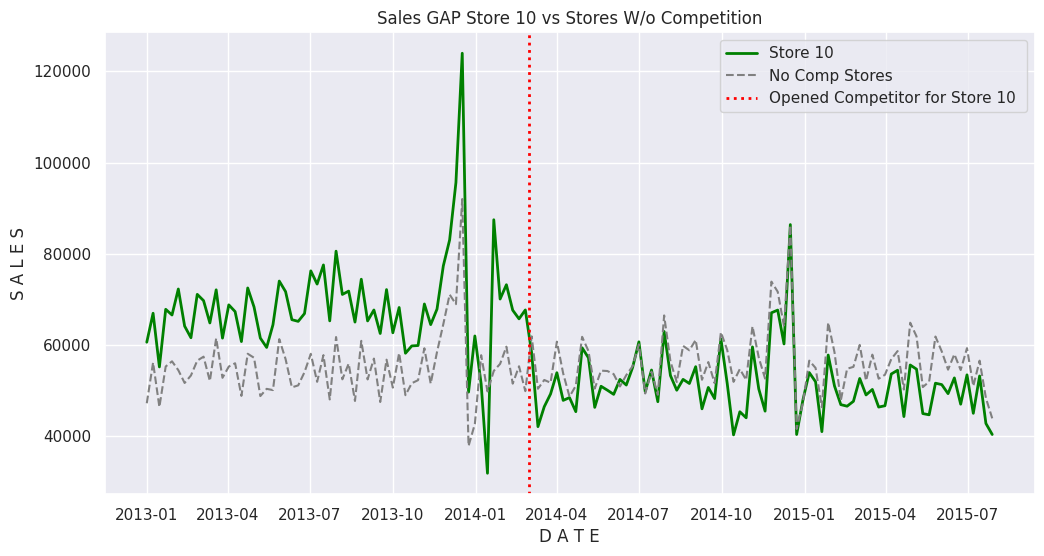

In [12]:
# Set Date of the intervention
intervention_date = pd.to_datetime("2014-03-01")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_sales.index, y_sales, label="Store 10", color='green', lw=2)
plt.plot(X_sales_mean.index, X_sales_mean, label="No Comp Stores", color='gray', linestyle='--')
plt.axvline(x=intervention_date, color="red", linestyle=":", lw=2, label="Opened Competitor for Store 10 ")
plt.xlabel("D A T E")
plt.ylabel("S A L E S")
plt.title("Sales GAP Store 10 vs Stores W/o Competition")
plt.legend()
plt.show()

# Synthetic Sample Linear Regression

Linear Regression to simulate the behavior of 10 without competition

In [13]:
# X & y sets
X_before = X_sales[:intervention_date]
X_after = X_sales[intervention_date:]
y_before = y_sales[:intervention_date]
y_after = y_sales[intervention_date:]

# Linear Regression fit
lm = LinearRegression(fit_intercept=False)
lm.fit(X_before, y_before)

# Predictions before and after intervention
preds_before = lm.predict(X_before)
preds_after = lm.predict(X_after)

# Synthetic Control Series
synthetic_series = pd.Series(
    np.concatenate([preds_before, preds_after]),
    index= X_sales.index
)

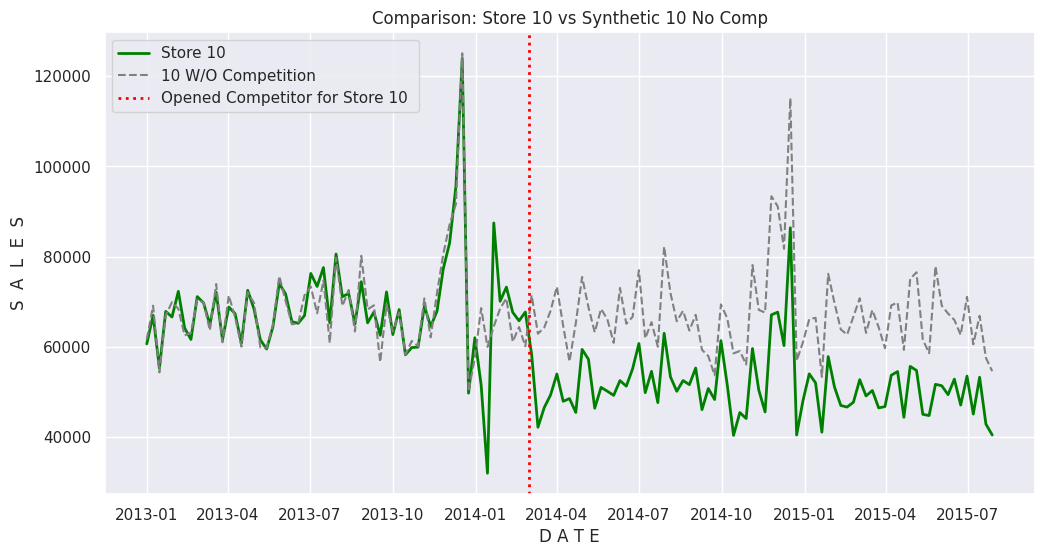

In [14]:
# Plot Synthetic (No competition) vs 10
plt.figure(figsize=(12, 6))
plt.plot(y_sales.index, y_sales, label="Store 10", color='green', lw=2)
plt.plot(synthetic_series.index, synthetic_series, label="10 W/O Competition", color='gray', linestyle='--')
plt.axvline(x=intervention_date, color="red", linestyle=":", lw=2, label="Opened Competitor for Store 10 ")
plt.xlabel("D A T E")
plt.ylabel("S  A  L  E  S")
plt.title("Comparison: Store 10 vs Synthetic 10 No Comp")
plt.legend()
plt.show()

In [15]:
# MAPE Store 10 versus Synthetic Store 10
mape_after = mean_absolute_percentage_error(y_after, preds_after)
print(f'MAPE after intervention: {mape_after:.2f}')

MAPE after intervention: 0.32


In [16]:
(df2
 .query('Store == "10"')
 .resample('7D', on='Date')
 .sum()
 .reset_index()
 .assign(after= lambda x: np.select([x.Date <= intervention_date, x.Date > intervention_date],
                                    [0, 1])) # add after Yes or No
 .assign(Store = lambda x: '10')
 .groupby(['Store', 'after'])
 .Sales.mean()
 .round(2)
 .reset_index()
 .pivot(index='Store', columns= 'after', values= 'Sales')
 .assign(difference= lambda x: x[1] - x[0],
         pct = lambda x: (x[1] - x[0]) / x[0])
 .round(2)
 )

after,0,1,difference,pct
Store,,,,
10,68199.28,51283.35,-16915.93,-0.25


# Before and After AB Test

Creating a Before vs. After Test to check if it points in the same way

First, need to wrangle the data to get the format

`Store` | `group` | `pre_sales` | `post_sales` | `dif_pp`


In [17]:
# Intervention date
intervention_date = pd.to_datetime("2014-03-01")

In [18]:
# Aggregating sales from daily to sales by 7 days
df_sales7d = (
    df2
    .pivot(index='Date', columns='Store', values='Sales') #pivot for resampling
    .resample('7D') #aggregate sales by 7 days
    .sum() #sum sales
    .reset_index() #reset to make Date as column again
    .melt(id_vars='Date', var_name='Store', value_name='Sales') # unpivot
    .assign(after= lambda x: np.select([x.Date <= intervention_date, x.Date > intervention_date],
                                        [0, 1])) # add after Yes or No
    .assign(group= lambda x: np.select([x.Store == "10", x.Store != "10"],
                                        ["treatment", "control"])) # add group treatment or control
    )

# View
df_sales7d.head(2)

,Date,Store,Sales,after,group
0,2013-01-01,01,70587.40,0,control
1,2013-01-08,01,91762.25,0,control


In [19]:
# Calculating averages and standard errors
ab_means = (df_sales7d
 .groupby(['group', 'after'])
 .agg({'Sales':['mean', 'std']})
 .round(2)
 )

ab_means

Sales          
                     mean       std
group     after                    
control   0      54923.05  28088.25
          1      56042.02  28700.70
treatment 0      68199.28  11526.38
          1      51283.35   7174.31

In [20]:
# Function to calc standard error of both samples
def std_error_two_samples(stdA, nA, stdB, nB):
    return np.sqrt( ((stdA**2) / nA ) + ( (stdB**2) / nB) )

In [21]:
def ab_test(data, group_col, target_col):
  '''
  Function to perform AB Test on a dataframe with A and B groups.
  - INPUTS:
  * data: dataframe = data with groups A and B
  * group_col: str = column name of the variable with groups names by observation
  '''

  # Get the groups A and B names for calculations
  a, b = data[group_col].unique()

  # get number of observations and standard deviations
  n_A = len( data.query("group == @a" ) )
  n_B = len( data.query("group == @b") )
  std_A = data.query("group == @a")[target_col].std()
  std_B = data.query("group == @b")[target_col].std()

  # Standard Error
  ste = std_error_two_samples(std_A, n_A, std_B, n_B)
  print('The calculated standard error is', ste)

  # A vs B Means Difference
  means_diff = data.query("group == @b")[target_col].mean() - data.query("group == @a")[target_col].mean()
  print(f'The difference in means Group B - A : {means_diff}')

  ## Calculating the p-Value
  # Considering both sample means are equal, the mean difference would be zero
  ab_mu = 0
  # The standard error is the one calculated for both samples
  ab_std = ste
  # We want to test for Prob of a number more extreme than that
  point_estimate = abs(means_diff)

  # Calculating Z score = "point_estimate - mean/std"
  Z = (point_estimate - ab_mu)/ab_std

  # Use the cumulative distribution function (CDF) to find the probability
  probability = scs.norm.cdf(Z)

  print("P-Value (two tails):", 2*(1-probability))

  # create 95% confidence interval for the Test
  ci = scs.norm(loc=means_diff, scale=ste).interval(confidence= 0.95)
  print(f'confidence interval with 95% confidence is {np.round(ci,2)}')

In [22]:
print('Control Before vs After:')
ab_test(data=  df_sales7d.query('group == "control"').rename(columns={'group':'grp','after':'group'}),
        group_col= 'group',
        target_col = 'Sales')

print('---------------------------------------------------------------------')

print('Treatment Before vs After:')
ab_test(data=  df_sales7d.query('group == "treatment"').rename(columns={'group':'grp','after':'group'}),
        group_col= 'group',
        target_col = 'Sales')

Control Before vs After:
The calculated standard error is 1635.206108090877
The difference in means Group B - A : 1118.971107665042
P-Value (two tails): 0.49378591381056647
confidence interval with 95% confidence is [-2085.97  4323.92]
---------------------------------------------------------------------
Treatment Before vs After:
The calculated standard error is 1695.1522766982898
The difference in means Group B - A : -16915.930695613657
P-Value (two tails): 0.0
confidence interval with 95% confidence is [-20238.37 -13593.49]


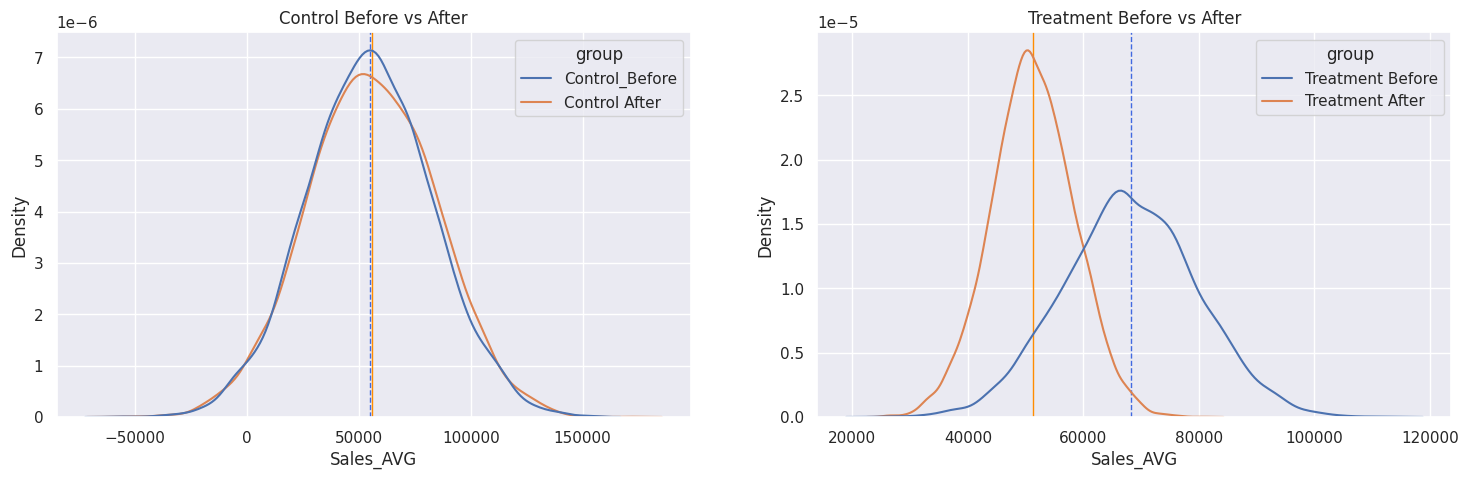

In [23]:
plt.figure(figsize=(18, 5))

# Control Samples Before vs. After
# Creating Normal Distribution of both Control samples
plt.subplot(1, 2, 1)
plot_a = np.random.normal(loc= ab_means.iloc[0,0], scale= ab_means.iloc[0,1], size=10000)
plot_b = np.random.normal(loc= ab_means.iloc[1,0], scale= ab_means.iloc[1,1], size=10000)
plot = pd.DataFrame({'group': ['Control_Before']*10000 + ['Control After']*10000,
                     'Sales_AVG': np.concatenate([plot_a, plot_b])})
# Intervention date line
plt.axvline(x=ab_means.iloc[0,0], color="royalblue", linestyle="--", lw=1)
plt.axvline(x=ab_means.iloc[1,0], color="darkorange", lw=1)
sns.kdeplot(plot, x='Sales_AVG', hue='group')
plt.title('Control Before vs After');

plt.subplot(1, 2, 2)
# Treatment Samples Before vs. After
# Creating Normal Distribution of both Treatment samples
plot_a = np.random.normal(loc= ab_means.iloc[2,0], scale= ab_means.iloc[2,1], size=10000)
plot_b = np.random.normal(loc= ab_means.iloc[3,0], scale= ab_means.iloc[3,1], size=10000)
plot = pd.DataFrame({'group': ['Treatment Before']*10000 + ['Treatment After']*10000,
                     'Sales_AVG': np.concatenate([plot_a, plot_b])})
# Intervention date line
plt.axvline(x=ab_means.iloc[2,0], color="royalblue", linestyle="--", lw=1)
plt.axvline(x=ab_means.iloc[3,0], color="darkorange", lw=1)
sns.kdeplot(plot, x='Sales_AVG', hue='group')
plt.title('Treatment Before vs After');

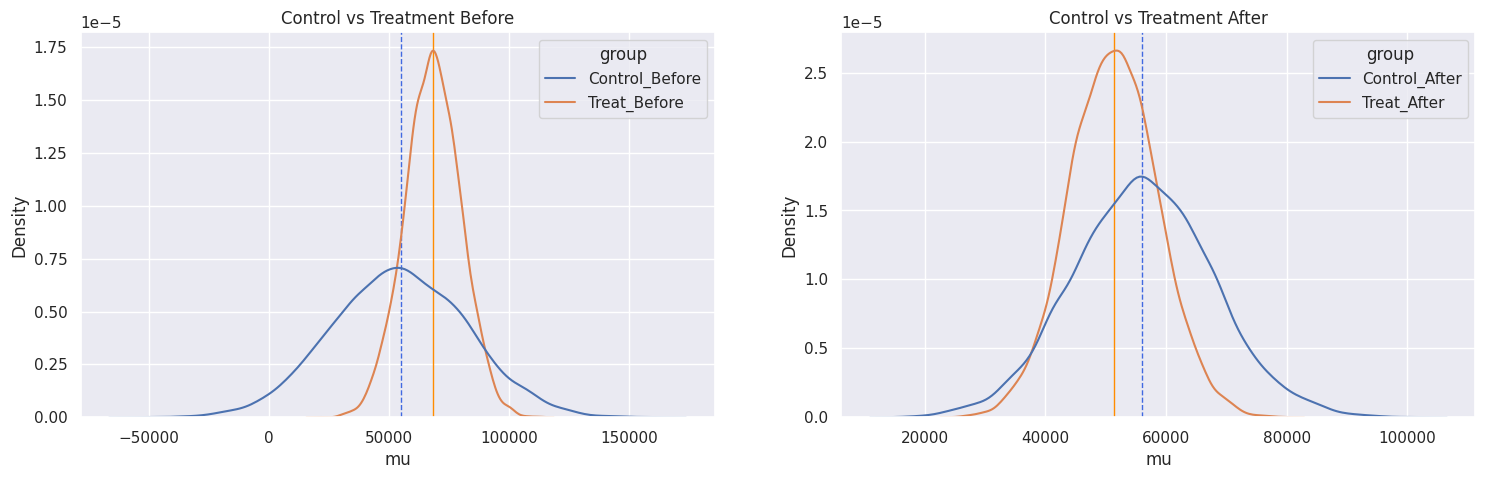

In [24]:
# Set figure size
plt.figure(figsize=(18, 5))

# Plot 1
plt.subplot(1, 2, 1)
# Control vs Treatment Samples Before
# Creating Normal Distribution of both samples
plot_a = np.random.normal(loc= ab_means.iloc[0,0], scale= ab_means.iloc[0,1], size=10000)
plot_b = np.random.normal(loc= ab_means.iloc[2,0], scale= ab_means.iloc[2,1], size=10000)
plot = pd.DataFrame({'group': ['Control_Before']*10000 + ['Treat_Before']*10000,
                     'mu': np.concatenate([plot_a, plot_b])})

plt.axvline(x=ab_means.iloc[0,0], color="royalblue", linestyle="--", lw=1)
plt.axvline(x=ab_means.iloc[2,0], color="darkorange", lw=1)
sns.kdeplot(plot, x='mu', hue='group')
plt.title('Control vs Treatment Before');

# Plot 2
# Control vs Treatment Samples After
plt.subplot(1, 2, 2)
# Creating Normal Distribution of both samples
plot_a = np.random.normal(loc= ab_means.iloc[1,0], scale= ab_means.iloc[2,1], size=10000)
plot_b = np.random.normal(loc= ab_means.iloc[3,0], scale= ab_means.iloc[3,1], size=10000)
plot = pd.DataFrame({'group': ['Control_After']*10000 + ['Treat_After']*10000,
                     'mu': np.concatenate([plot_a, plot_b])})

plt.axvline(x=ab_means.iloc[1,0], color="royalblue", linestyle="--", lw=1)
plt.axvline(x=ab_means.iloc[3,0], color="darkorange", lw=1)
sns.kdeplot(plot, x='mu', hue='group')
plt.title('Control vs Treatment After');

# Causal Impact

In [ ]:
# !pip install causalimpact --quiet
from causalimpact import CausalImpact

# Create dataset with mean of the control stores (x) and the test store (y)
df4 = (pd.concat([X_sales_mean.round(2), y_sales], axis=1)
       .rename(columns={0: 'x', 'Sales': 'y'})
       .reindex(columns=['y', 'x'])
       )

# Run Causal Impact
impact = CausalImpact(data=df4,
                      pre_period=[pd.to_datetime("2013-01-01"), pd.to_datetime("2014-03-04")],
                      post_period=[pd.to_datetime("2014-03-11"), pd.to_datetime("2015-07-28")])

impact.run()

# Plot result
impact.plot()

# Print Summary
impact.summary()

# Prin Report
impact.summary(output="report")